# Cleaning and Preprocessing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import zipfile
import pandas as pd
from io import StringIO
from scipy.io import arff
import requests

# Function to download the file from Google Drive
def download_file_from_google_drive(id, destination):
    url = f"https://drive.google.com/uc?export=download&id={id}"
    response = requests.get(url, stream=True)
    with open(destination, "wb") as f:
        f.write(response.content)

def unzip_and_read_arff(zip_file_path, arff_file_name):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            with zip_ref.open(arff_file_name) as arff_file:
                arff_data = arff_file.read().decode('utf-8')
                arff_data_stream = StringIO(arff_data)
                data, meta = arff.loadarff(arff_data_stream)
                df = pd.DataFrame(data)
                return df
    except FileNotFoundError:
        print(f"File not found: {zip_file_path}")
    except zipfile.BadZipFile:
        print(f"Invalid zip file: {zip_file_path}")
    except KeyError:
        print(f"ARFF file not found in zip: {arff_file_name}")

# Google Drive file ID
file_id = "1xBqxR2Ee8DaMNBHCIWxOtCYQ7_03omM-"
# Destination to save the downloaded zip file
zip_file_path = "airlines.arff (1).zip"

# Download the file
download_file_from_google_drive(file_id, zip_file_path)

# Name of the ARFF file within the zip
arff_file_name = "airlines.arff"

# Unzip and read the ARFF file into a DataFrame
elec_df = unzip_and_read_arff(zip_file_path, arff_file_name)
print(elec_df)

       Airline  Flight AirportFrom AirportTo DayOfWeek    Time  Length Delay
0        b'CO'   269.0      b'SFO'    b'IAH'      b'3'    15.0   205.0  b'1'
1        b'US'  1558.0      b'PHX'    b'CLT'      b'3'    15.0   222.0  b'1'
2        b'AA'  2400.0      b'LAX'    b'DFW'      b'3'    20.0   165.0  b'1'
3        b'AA'  2466.0      b'SFO'    b'DFW'      b'3'    20.0   195.0  b'1'
4        b'AS'   108.0      b'ANC'    b'SEA'      b'3'    30.0   202.0  b'0'
...        ...     ...         ...       ...       ...     ...     ...   ...
539378   b'CO'   178.0      b'OGG'    b'SNA'      b'5'  1439.0   326.0  b'0'
539379   b'FL'   398.0      b'SEA'    b'ATL'      b'5'  1439.0   305.0  b'0'
539380   b'FL'   609.0      b'SFO'    b'MKE'      b'5'  1439.0   255.0  b'0'
539381   b'UA'    78.0      b'HNL'    b'SFO'      b'5'  1439.0   313.0  b'1'
539382   b'US'  1442.0      b'LAX'    b'PHL'      b'5'  1439.0   301.0  b'1'

[539383 rows x 8 columns]


In [3]:
# Decode byte type columns to strings and strip leading/trailing whitespace
columns = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Delay']
for col in columns:
    air_df[col] = air_df[col].str.decode('utf-8').str.strip()


In [4]:
# Convert 'Delay' and 'DayOfWeek' column to integer
air_df['Delay'] = air_df['Delay'].astype(int)
air_df['DayOfWeek'] = air_df['DayOfWeek'].astype(int)

In [5]:
print(air_df.dtypes)

Airline         object
Flight         float64
AirportFrom     object
AirportTo       object
DayOfWeek        int64
Time           float64
Length         float64
Delay            int64
dtype: object


In [6]:
print(len(air_df))

539383


In [7]:
# Value counts for 'Delay' column
delay_counts = air_df['Delay'].value_counts()
print(delay_counts)

Delay
0    299119
1    240264
Name: count, dtype: int64


In [8]:
# Check for missing values
print(air_df.isnull().sum())

Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64


In [9]:
import numpy as np
# Identify outliers 
def find_outliers(df):
    outliers = {}
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:  # Only apply to numerical columns
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

# Find outliers in each column
outliers = find_outliers(air_df)
for feature, outlier_values in outliers.items():
    print(f"Outliers in {feature}:")
    print(len(outlier_values))
    print()

Outliers in Flight:
0

Outliers in DayOfWeek:
0

Outliers in Time:
0

Outliers in Length:
25650

Outliers in Delay:
0



In [10]:
from sklearn.preprocessing import StandardScaler

# Scale numerical features (Time, Length)
scaler = StandardScaler()
air_df[['Time', 'Length']] = scaler.fit_transform(air_df[['Time', 'Length']])

In [11]:
# Split the dataset based on 'DayOfWeek'
weekday_df = air_df[air_df['DayOfWeek'].isin([1, 2, 3, 4, 5])]
weekend_df = air_df[air_df['DayOfWeek'].isin([6, 7])]

print("Weekday Data:")
print(weekday_df)

print("\nWeekend Data:")
print(weekend_df)

Weekday Data:
       Airline  Flight AirportFrom AirportTo  DayOfWeek      Time    Length  \
0           CO   269.0         SFO       IAH          3 -2.833092  1.038237   
1           US  1558.0         PHX       CLT          3 -2.833092  1.280689   
2           AA  2400.0         LAX       DFW          3 -2.815110  0.467761   
3           AA  2466.0         SFO       DFW          3 -2.815110  0.895618   
4           AS   108.0         ANC       SEA          3 -2.779144  0.995451   
...        ...     ...         ...       ...        ...       ...       ...   
539378      CO   178.0         OGG       SNA          5  2.288369  2.763925   
539379      FL   398.0         SEA       ATL          5  2.288369  2.464425   
539380      FL   609.0         SFO       MKE          5  2.288369  1.751331   
539381      UA    78.0         HNL       SFO          5  2.288369  2.578520   
539382      US  1442.0         LAX       PHL          5  2.288369  2.407378   

        Delay  
0           1  
1    

In [12]:
# Perform label encoding on categorical columns in weekday_df and weekend_df

from sklearn.preprocessing import LabelEncoder

# Create LabelEncoder objects
label_encoder_airline = LabelEncoder()
label_encoder_from = LabelEncoder()
label_encoder_to = LabelEncoder()

# Fit and transform on weekday_df
weekday_df['Airline'] = label_encoder_airline.fit_transform(weekday_df['Airline'])
weekday_df['AirportFrom'] = label_encoder_from.fit_transform(weekday_df['AirportFrom'])
weekday_df['AirportTo'] = label_encoder_to.fit_transform(weekday_df['AirportTo'])

# Fit and transform on weekend_df
weekend_df['Airline'] = label_encoder_airline.fit_transform(weekend_df['Airline'])
weekend_df['AirportFrom'] = label_encoder_from.fit_transform(weekend_df['AirportFrom'])
weekend_df['AirportTo'] = label_encoder_to.fit_transform(weekend_df['AirportTo'])

print("Weekday Data with Encoded Labels:")
print(weekday_df.head())

print("\nWeekend Data with Encoded Labels:")
print(weekend_df.head())


Weekday Data with Encoded Labels:
   Airline  Flight  AirportFrom  AirportTo  DayOfWeek      Time    Length  \
0        4   269.0          252        134          3 -2.833092  1.038237   
1       14  1558.0          216         59          3 -2.833092  1.280689   
2        1  2400.0          153         79          3 -2.815110  0.467761   
3        1  2466.0          252         79          3 -2.815110  0.895618   
4        2   108.0           13        251          3 -2.779144  0.995451   

   Delay  
0      1  
1      1  
2      1  
3      1  
4      0  

Weekend Data with Encoded Labels:
       Airline  Flight  AirportFrom  AirportTo  DayOfWeek      Time    Length  \
53799        5  2344.0          153         71          6 -2.851075  1.180856   
53800        4   269.0          253        135          6 -2.833092  1.009713   
53801       14  1558.0          217         60          6 -2.833092  1.280689   
53802        1  2400.0          154         80          6 -2.815110  0.467761 

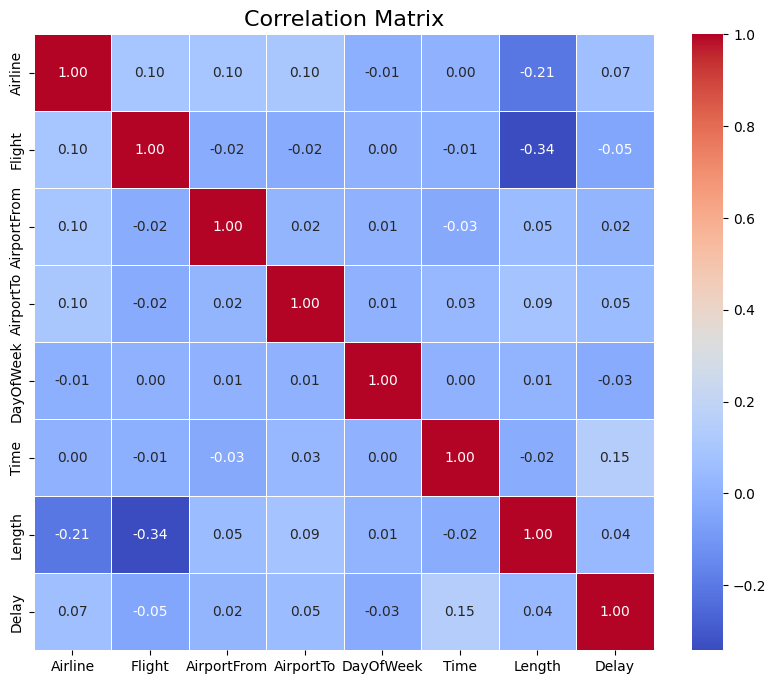

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
merged_df = pd.concat([weekday_df, weekend_df], ignore_index=True)

# Calculate the correlation matrix
corr_matrix = merged_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

# Functions

In [14]:
!pip install SHAP


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [15]:
# Function to calculate Permutation Importance Scores for chunks
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
def calculate_permutation_importance_chunks(model, X, y, chunk_size=1000):

  all_importance_scores = []

  for i in range(0, len(X), chunk_size):
    chunk_X = X[i: i + chunk_size]
    chunk_y = y[i: i + chunk_size]

    if hasattr(model, 'get_weights'):
      results = permutation_importance(model, chunk_X, chunk_y, scoring='neg_root_mean_squared_error', random_state=42)
    else:
      results = permutation_importance(model, chunk_X, chunk_y, scoring='accuracy', random_state=42)
    importance_scores = results.importances_mean
    all_importance_scores.append(importance_scores)

  return pd.DataFrame(all_importance_scores, columns=X.columns)

In [16]:
# Function to calculate permutation importance values and accuracy values for each window
def calculate_permutation_importance_all_values(model, X, y, chunk_size=1000):
    all_importance_data = []
    accuracy_data = []

    for i in range(0, len(X), chunk_size):
        chunk_X = X.iloc[i: i + chunk_size]
        chunk_y = y.iloc[i: i + chunk_size]
        chunk_number = i // chunk_size + 1

        if hasattr(model, 'get_weights'):  # Neural network case
            predictions = (model.predict(chunk_X) > 0.5).astype("int32").flatten()
            accuracy = accuracy_score(chunk_y, predictions)
            accuracy_data.append([chunk_number, accuracy])

            # Calculate permutation importance
            results = permutation_importance(model, chunk_X, chunk_y, scoring='neg_root_mean_squared_error', random_state=42)
        
        else:  # Non-neural network case
            accuracy = model.score(chunk_X, chunk_y)
            accuracy_data.append([chunk_number, accuracy])

            # Calculate permutation importance
            results = permutation_importance(model, chunk_X, chunk_y, scoring='accuracy', random_state=42)

        importances = results.importances

        # Reshape the data and add the chunk number
        for j in range(importances.shape[1]):  
            if j < len(chunk_X.columns):
                for k in range(importances.shape[0]):
                    all_importance_data.append([chunk_number, X.columns[j], importances[k, j]])

    importance_df = pd.DataFrame(all_importance_data, columns=['chunk_number', 'feature', 'importance'])
    accuracy_df = pd.DataFrame(accuracy_data, columns=['chunk_number', 'accuracy'])

    return importance_df, accuracy_df


In [17]:
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [18]:
# Function to plot the permutation importance scores
import matplotlib.pyplot as plt
import seaborn as sns
def plot_permutation_importance(importance_df):
# Calculate mean importance scores across chunks
  mean_importance_scores = importance_df.mean()

# Create a DataFrame for plotting
  mean_importance_df = pd.DataFrame({
      'Feature': mean_importance_scores.index,
      'Importance': mean_importance_scores.values
  })
  print(mean_importance_df)
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Feature', y='Importance', data=mean_importance_df, palette='viridis')
  plt.title('Mean Permutation Importance of Features')
  plt.xlabel('Feature')
  plt.ylabel('Mean Importance')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
  plt.tight_layout()
  plt.show()
  return mean_importance_df

In [19]:
# Define input features and target variable
X = weekday_df[['Airline','Flight','AirportFrom', 'AirportTo','Time','Length']]
y = weekday_df['Delay']
# Define input features and target variable for weekend dataset
X2 = weekend_df[['Airline','Flight','AirportFrom', 'AirportTo','Time','Length']]
y2 = weekend_df['Delay']

In [20]:
# Function to train test split the dataframe
from sklearn.model_selection import train_test_split
def train_test_split_df(X, y, test_size=0.3, random_state=42):
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
  return X_train, X_test, y_train, y_test

In [21]:
# Functions to plot SHAP graph
from scipy.stats import skew
import shap
def plot_linear_shap_graph(X,model):
  masker = shap.maskers.Independent(X)
  explainer = shap.LinearExplainer(model, masker=masker)
  shap_values = explainer.shap_values(X)
  shap.summary_plot(shap_values, X)
  shap_df = pd.DataFrame(shap_values, columns=X.columns)
  return shap_df
    
def plot_tree_shap_graph(X,model):
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X, approximate=True)
  shap.summary_plot(shap_values[:, :, 1], X)
  shap_df = pd.DataFrame(shap_values[:, :, 1], columns=X.columns)
  return shap_df

def plot_nn_shap_graph(X, model):
  X_sample = X[:1000]
  X_sample_np = X_sample.values
  explainer = shap.DeepExplainer(model, X_sample)
  shap_values = explainer.shap_values(X_sample_np)
  shap_values_reshaped = shap_values.reshape(1000, 6)
  shap.summary_plot(shap_values_reshaped, X_sample)
  shap_df = pd.DataFrame(shap_values_reshaped, columns=X.columns)
  return shap_df

In [22]:
# Calculate skewness, variance, mean from SHAP values
import numpy as np
def calculate_shap_metrics_rf(shap_values,features):
  metrics = []
  for i, feature_name in enumerate(features):
    feature_shap_values = shap_values[:,i,1]
    mean_value = np.mean(feature_shap_values)
    variance_value = np.var(feature_shap_values)
    skewness_value = skew(feature_shap_values)
    metrics.append({
        'feature': feature_name,
        'mean': mean_value,
        'variance': variance_value,
        'skewness': skewness_value
    })
  metrics_df = pd.DataFrame(metrics)
  return metrics_df

# Calculate skewness, variance, mean from SHAP values
def calculate_shap_metrics_lr(shap_values):
    metrics = []
    for feature_name in shap_values.columns:
        feature_shap_values = shap_values[feature_name].values  # Extract SHAP values for the feature
        mean_value = np.mean(feature_shap_values)
        variance_value = np.var(feature_shap_values)
        skewness_value = skew(feature_shap_values)
        metrics.append({
            'feature': feature_name,
            'mean': mean_value,
            'variance': variance_value,
            'skewness': skewness_value
        })
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

In [23]:
# Function to find statistical differences between importance scores
from scipy.stats import ttest_ind, ks_2samp

def compare_importance_scores(weekday_df, weekend_df, alpha=0.05):
    significant_features_ttest = []
    significant_features_ks = []

    for feature in weekday_df.columns:
        weekday_scores = weekday_df[feature]
        weekend_scores = weekend_df[feature]
        
        # Perform T-test
        t_stat, p_value_ttest = ttest_ind(weekday_scores, weekend_scores, equal_var=False)
        
        # Perform KS-test
        ks_stat, p_value_ks = ks_2samp(weekday_scores, weekend_scores)
        
        # Check if the p-value is less than the alpha (significance level)
        if p_value_ttest < alpha:
            significant_features_ttest.append((feature, p_value_ttest))
        
        if p_value_ks < alpha:
            significant_features_ks.append((feature, p_value_ks))
    
    print(f"Features with significant differences (p < {alpha}) according to the T-test:")
    for feature, p_value in significant_features_ttest:
        print(f"- {feature}: p-value = {p_value:.4f}")
    
    print(f"\nFeatures with significant differences (p < {alpha}) according to the KS-test:")
    for feature, p_value in significant_features_ks:
        print(f"- {feature}: p-value = {p_value:.4f}")


In [24]:
# Function to perform t-test and KS-test on MCR bounds
import scipy.stats as stats
def compare_mcr_bounds(mcr_weekday_df, mcr_weekend_df):

    significant_features_ttest = []
    significant_features_kstest = []
    p_values_ttest = {}
    p_values_kstest = {}
    
    # Compute the differences for both datasets
    mcr_weekday_df['MCR_Diff'] = mcr_weekday_df['MCR+'] - mcr_weekday_df['MCR-']
    mcr_weekend_df['MCR_Diff'] = mcr_weekend_df['MCR+'] - mcr_weekend_df['MCR-']
    
    for feature in mcr_weekday_df['Feature']:
        # Get the differences for the feature from both dataframes
        weekday_mcr_diff = mcr_weekday_df[mcr_weekday_df['Feature'] == feature]['MCR_Diff'].values
        weekend_mcr_diff = mcr_weekend_df[mcr_weekend_df['Feature'] == feature]['MCR_Diff'].values
        
        # Perform t-test
        ttest = stats.ttest_ind(weekday_mcr_diff, weekend_mcr_diff, equal_var=False)
        p_values_ttest[feature] = ttest.pvalue
        
        # Perform KS-test
        kstest = stats.ks_2samp(weekday_mcr_diff, weekend_mcr_diff)
        p_values_kstest[feature] = kstest.pvalue
        
        # Check if the p-value for t-test is less than 0.05
        if ttest.pvalue < 0.05:
            significant_features_ttest.append((feature, ttest.pvalue))
        
        # Check if the p-value for KS-test is less than 0.05
        if kstest.pvalue < 0.05:
            significant_features_kstest.append((feature, kstest.pvalue))
    
    print("Features with significant differences (p < 0.05) according to the T-test:")
    for feature, p_value in significant_features_ttest:
        print(f"- {feature}: p-value = {p_value:.4f}")
    
    print("\nFeatures with significant differences (p < 0.05) according to the KS-test:")
    for feature, p_value in significant_features_kstest:
        print(f"- {feature}: p-value = {p_value:.4f}")

In [25]:
# Plot accuracy metrics across windows
def plot_trendlines(df1, df2):
    plt.figure(figsize=(10, 6))

    # Trendline for first DataFrame
    slope1, intercept1, _, _, _ = linregress(df1['chunk_number'], df1['accuracy'])
    plt.plot(df1['chunk_number'], intercept1 + slope1 * df1['chunk_number'], color='blue', linestyle='--', label='Weekday')

    # Trendline for second DataFrame
    slope2, intercept2, _, _, _ = linregress(df2['chunk_number'], df2['accuracy'])
    plt.plot(df2['chunk_number'], intercept2 + slope2 * df2['chunk_number'], color='red', linestyle='--', label='Weekend')

    plt.title('Trendlines for Accuracy over Time')
    plt.xlabel('Chunk Number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Model Logistic Regression

In [26]:
# Fit logistic regression model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Initialize and train the Decision Tree model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[49519 18313]
 [33115 22218]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.73      0.66     67832
           1       0.55      0.40      0.46     55333

    accuracy                           0.58    123165
   macro avg       0.57      0.57      0.56    123165
weighted avg       0.58      0.58      0.57    123165



In [27]:
# Make predictions on the weekend dataset
y2_pred = lr_model.predict(X2)

print("Confusion Matrix:")
print(confusion_matrix(y2, y2_pred))

print("\nClassification Report:")
print(classification_report(y2, y2_pred))

Confusion Matrix:
[[53088 20439]
 [33350 21958]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66     73527
           1       0.52      0.40      0.45     55308

    accuracy                           0.58    128835
   macro avg       0.57      0.56      0.56    128835
weighted avg       0.57      0.58      0.57    128835



In [28]:
# Calculate window wise permutation importance scores
weekday_lr_importance_df = calculate_permutation_importance_chunks(lr_model, X, y, chunk_size=5000)
weekend_lr_importance_df = calculate_permutation_importance_chunks(lr_model, X2, y2, chunk_size=5000)

In [29]:
weekend_lr_importance_df

,Airline,Flight,AirportFrom,AirportTo,Time,Length
0,0.002560,-0.004760,-0.000360,0.000680,0.001400,0.001000
1,0.015640,-0.003960,-0.001640,-0.002040,0.006880,0.005320
2,0.002040,-0.004000,-0.004680,0.001160,0.022040,-0.001000
3,0.007240,-0.004120,-0.001040,-0.001280,0.003400,0.002720
4,0.012080,0.004680,-0.002160,-0.000080,0.009480,0.016960
5,0.017960,0.013600,-0.002000,0.002880,0.001520,0.011040
6,-0.000800,-0.000600,0.000040,-0.001240,0.097280,0.000520
7,0.013960,-0.003160,-0.000440,0.000440,0.003960,0.013920
8,0.023320,0.000800,-0.001200,0.003440,-0.007000,0.003480
9,-0.002280,-0.002600,-0.001480,0.000000,0.007680,0.006360


In [30]:
# Statistically compare importance scores
compare_importance_scores(weekday_lr_importance_df, weekend_lr_importance_df)

Features with significant differences (p < 0.05) according to the T-test:

Features with significant differences (p < 0.05) according to the KS-test:


       Feature  Importance
0      Airline    0.011730
1       Flight    0.005312
2  AirportFrom   -0.000457
3    AirportTo    0.000308
4         Time    0.019097
5       Length    0.007230


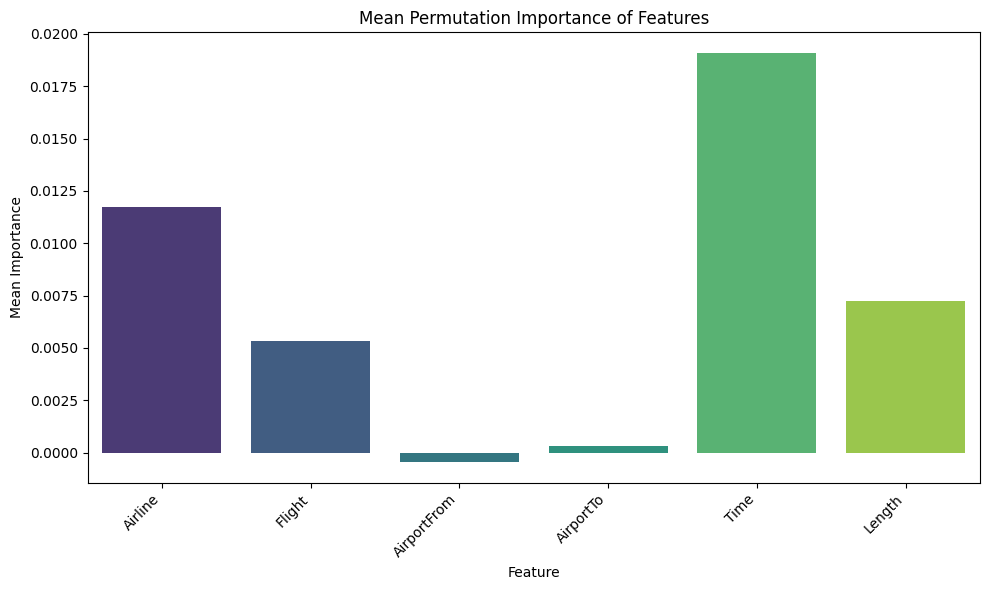

In [31]:
# Plot weekday importance scores
weekday_pi_df = plot_permutation_importance(weekday_lr_importance_df)

       Feature  Importance
0      Airline    0.011165
1       Flight    0.002518
2  AirportFrom   -0.000628
3    AirportTo    0.000189
4         Time    0.018206
5       Length    0.005678


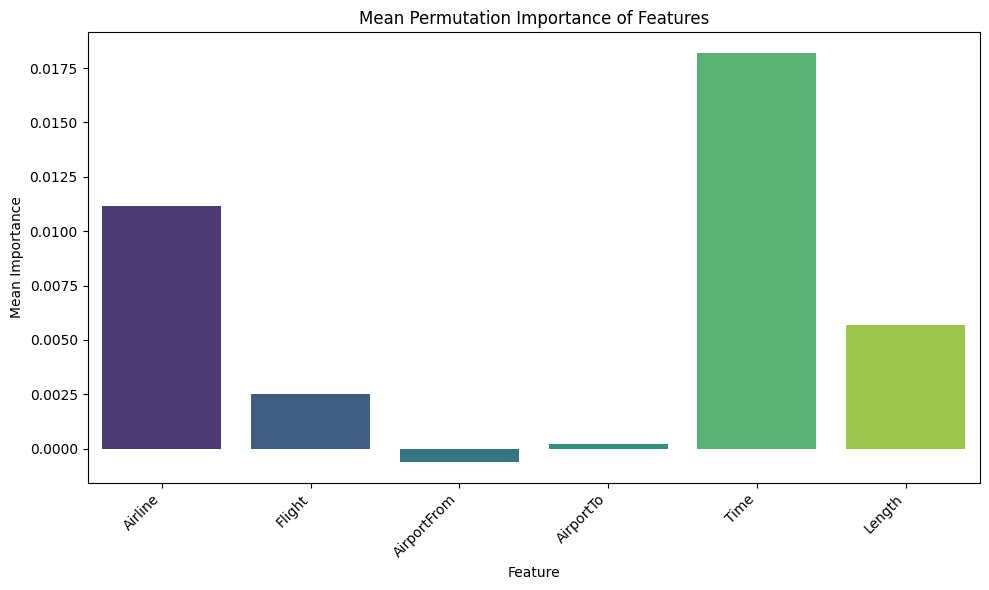

In [32]:
# Plot weekend permutation importance scores
weekend_pi_df = plot_permutation_importance(weekend_lr_importance_df)

In [33]:
# Calculate accuracy and importance scores chunk wise for statistical tests
lr_weekday_imp, lr_weekday_acc = calculate_permutation_importance_all_values(lr_model, X, y, chunk_size=5000)

In [34]:
# Calculate accuracy and importance scores chunk wise for statistical tests
lr_weekend_imp, lr_weekend_acc = calculate_permutation_importance_all_values(lr_model, X2, y2, chunk_size=5000)

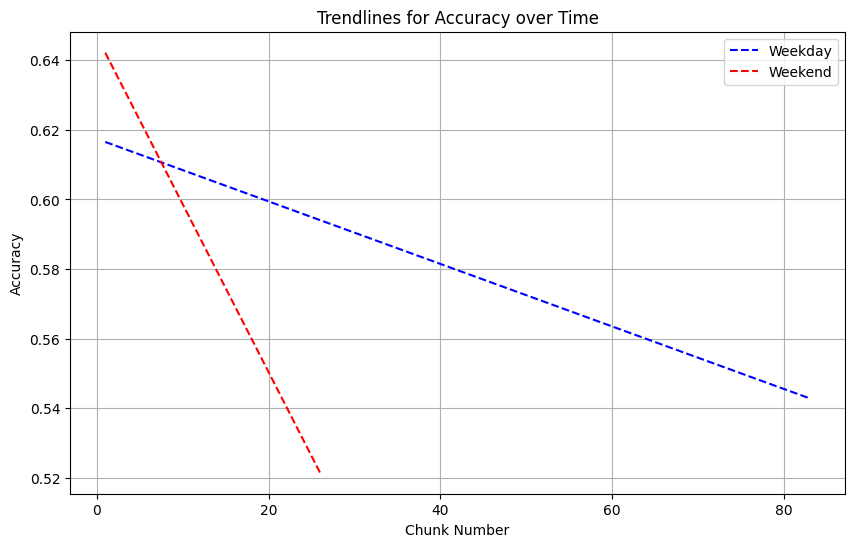

In [36]:
# Plotting accuracy scores
from scipy.stats import linregress
plot_trendlines(lr_weekday_acc, lr_weekend_acc)

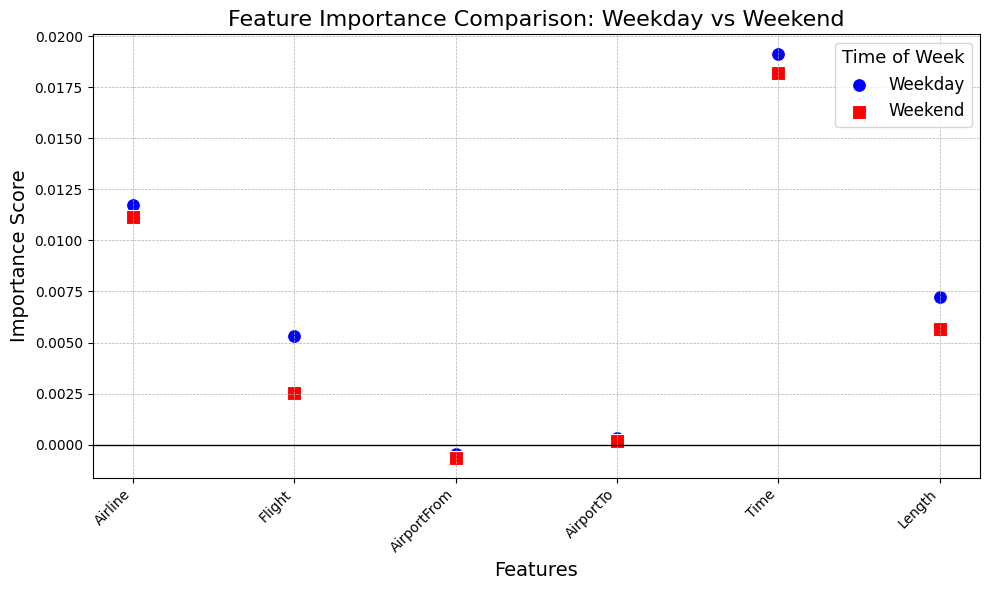

In [37]:
# Plot mean permutation importance scores

plt.figure(figsize=(10, 6))

# Plot the weekday feature importances
sns.scatterplot(x=weekday_pi_df['Feature'], y=weekday_pi_df['Importance'], 
                color='blue', s=100, marker='o', label='Weekday')

# Plot the weekend feature importances
sns.scatterplot(x=weekend_pi_df['Feature'], y=weekend_pi_df['Importance'], 
                color='red', s=100, marker='s', label='Weekend')

plt.title('Feature Importance Comparison: Weekday vs Weekend', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black', linewidth=1.0)  # Adding a horizontal line at y=0 for reference
plt.legend(title='Time of Week', title_fontsize='13', fontsize='12')
plt.tight_layout()
plt.show()

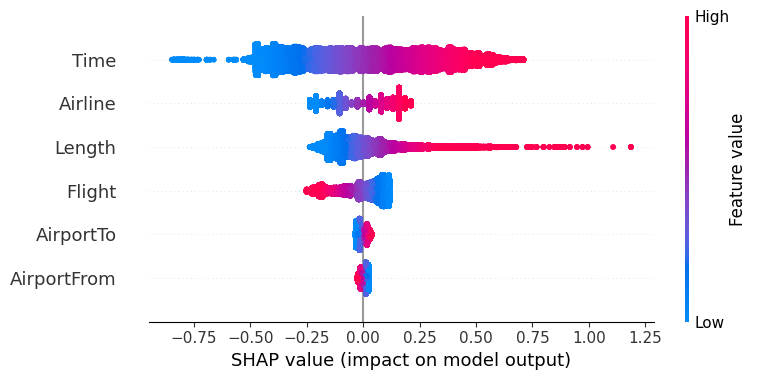

In [38]:
# SHAP Summary plot for weekday dataset
lr_weekday_shap_values = plot_linear_shap_graph(X_test,lr_model)

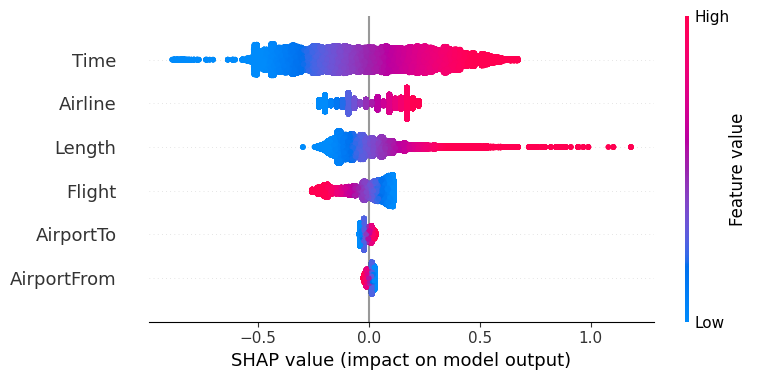

In [39]:
# SHAP Summary plot for weekend dataset
lr_weekend_shap_values = plot_linear_shap_graph(X2,lr_model)

In [40]:
# Calculate mean, variance and skewness for weekday dataset
lr_weekday_shap_metrics = calculate_shap_metrics_lr(lr_weekday_shap_values)
lr_weekday_shap_metrics

,feature,mean,variance,skewness
0,Airline,0.011089,0.019518,-0.301983
1,Flight,0.002558,0.009543,-0.862807
2,AirportFrom,0.000492,0.000205,0.059268
3,AirportTo,0.000887,0.000419,-0.049029
4,Time,0.016489,0.092269,0.074829
5,Length,0.005245,0.024487,1.489549


In [41]:
# Calculate mean, variance and skewness for weekend dataset
lr_weekend_shap_metrics = calculate_shap_metrics_lr(lr_weekend_shap_values)
lr_weekend_shap_metrics

,feature,mean,variance,skewness
0,Airline,0.020290,0.019562,-0.264434
1,Flight,-0.002514,0.009366,-0.867058
2,AirportFrom,0.001882,0.000205,0.075803
3,AirportTo,-0.004465,0.000416,-0.076716
4,Time,-0.019293,0.088775,0.084104
5,Length,0.005700,0.025847,1.467259


In [42]:
# Find statistical differences in SHAP metrics
import numpy as np
from scipy.stats import ttest_ind, ks_2samp

train_stats = lr_weekday_shap_metrics.set_index('feature').to_dict('index')
test_stats = lr_weekend_shap_metrics.set_index('feature').to_dict('index')

n_samples = 1000
significance_level = 0.05


def simulate_shap_values(mean, variance, n_samples):
    return np.random.normal(loc=mean, scale=np.sqrt(variance), size=n_samples)

# Simulating SHAP values for training and testing datasets
shap_train = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
              for feature, stats in train_stats.items()}

shap_test = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
             for feature, stats in test_stats.items()}

# Perform t-test and KS-test for each feature
test_results = {}
for feature in shap_train.keys():
    t_stat, t_p_value = ttest_ind(shap_train[feature], shap_test[feature], equal_var=True)
    ks_stat, ks_p_value = ks_2samp(shap_train[feature], shap_test[feature])
    
    # Determine if the results are significant
    t_significant = t_p_value < significance_level
    ks_significant = ks_p_value < significance_level
    
    test_results[feature] = {
        't-test': {'t_stat': t_stat, 'p_value': t_p_value, 'significant': t_significant},
        'ks-test': {'ks_stat': ks_stat, 'p_value': ks_p_value, 'significant': ks_significant}
    }

for feature, results in test_results.items():
    print(f"Feature: {feature}")
    print(f"  t-test: t_stat={results['t-test']['t_stat']:.4f}, p_value={results['t-test']['p_value']:.4e}, "
          f"{'Significant' if results['t-test']['significant'] else 'Not Significant'}")
    print(f"  KS-test: ks_stat={results['ks-test']['ks_stat']:.4f}, p_value={results['ks-test']['p_value']:.4e}, "
          f"{'Significant' if results['ks-test']['significant'] else 'Not Significant'}")
    print()

print("Summary of features with significant differences:")
for feature, results in test_results.items():
    if results['t-test']['significant'] or results['ks-test']['significant']:
        print(f"Feature: {feature}")
        if results['t-test']['significant']:
            print(f"  Significant difference in mean based on t-test (p={results['t-test']['p_value']:.4e})")
        if results['ks-test']['significant']:
            print(f"  Significant difference in distribution based on KS-test (p={results['ks-test']['p_value']:.4e})")

Feature: Airline
  t-test: t_stat=0.0653, p_value=9.4796e-01, Not Significant
  KS-test: ks_stat=0.0290, p_value=7.9466e-01, Not Significant

Feature: Flight
  t-test: t_stat=0.3970, p_value=6.9144e-01, Not Significant
  KS-test: ks_stat=0.0310, p_value=7.2283e-01, Not Significant

Feature: AirportFrom
  t-test: t_stat=-0.4156, p_value=6.7775e-01, Not Significant
  KS-test: ks_stat=0.0410, p_value=3.7012e-01, Not Significant

Feature: AirportTo
  t-test: t_stat=3.3420, p_value=8.4717e-04, Significant
  KS-test: ks_stat=0.0880, p_value=8.6136e-04, Significant

Feature: Time
  t-test: t_stat=1.3954, p_value=1.6305e-01, Not Significant
  KS-test: ks_stat=0.0440, p_value=2.8780e-01, Not Significant

Feature: Length
  t-test: t_stat=1.1707, p_value=2.4188e-01, Not Significant
  KS-test: ks_stat=0.0360, p_value=5.3628e-01, Not Significant

Summary of features with significant differences:
Feature: AirportTo
  Significant difference in mean based on t-test (p=8.4717e-04)
  Significant differe

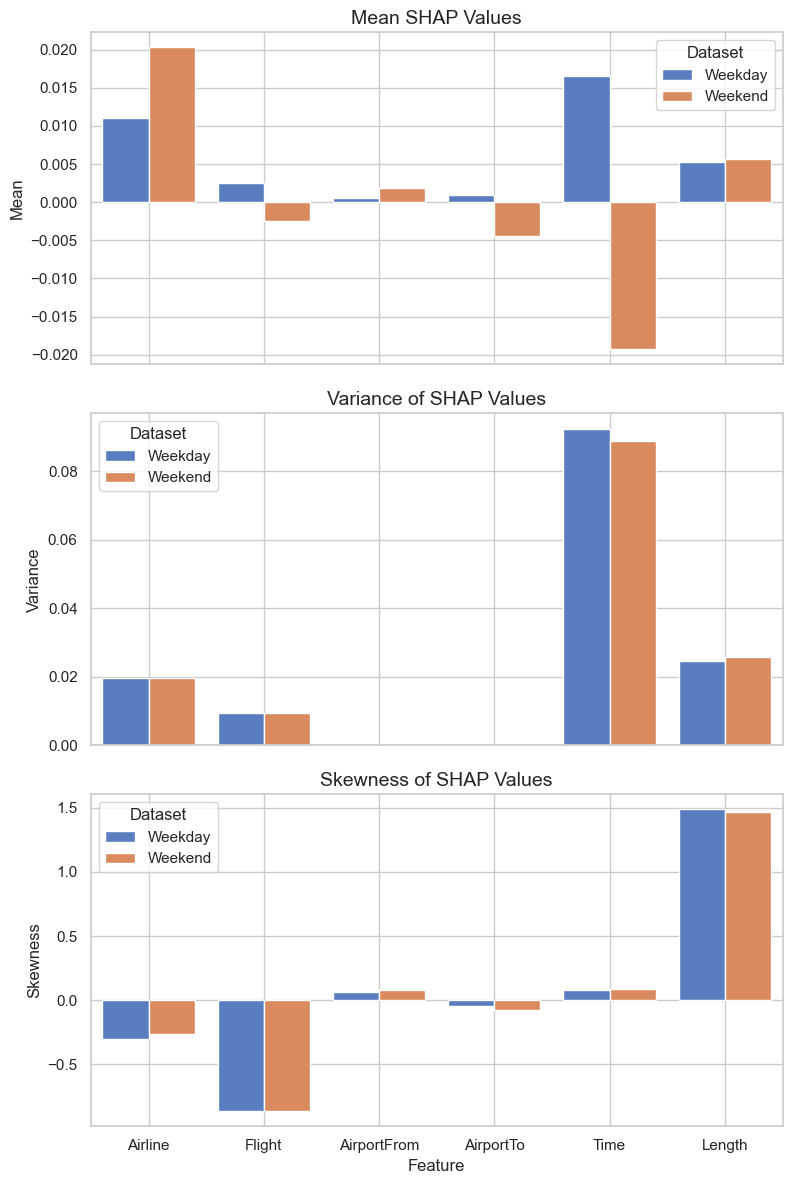

In [43]:
# Plot SHAP metrics

lr_weekday_shap_metrics['Dataset'] = 'Weekday'
lr_weekend_shap_metrics['Dataset'] = 'Weekend'

# Combine the two dataframes into one
combined_shap_metrics = pd.concat([lr_weekday_shap_metrics, lr_weekend_shap_metrics])

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
palette = sns.color_palette("muted")
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot mean SHAP values
sns.barplot(ax=axes[0], x='feature', y='mean', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[0].set_title('Mean SHAP Values', fontsize=14)
axes[0].set_ylabel('Mean', fontsize=12)
axes[0].grid(True)

# Plot variance of SHAP values
sns.barplot(ax=axes[1], x='feature', y='variance', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[1].set_title('Variance of SHAP Values', fontsize=14)
axes[1].set_ylabel('Variance', fontsize=12)
axes[1].grid(True)

# Plot skewness of SHAP values
sns.barplot(ax=axes[2], x='feature', y='skewness', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[2].set_title('Skewness of SHAP Values', fontsize=14)
axes[2].set_xlabel('Feature', fontsize=12)
axes[2].set_ylabel('Skewness', fontsize=12)
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Model Random Forest

In [44]:
# Fit Random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define input features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=20, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))


Confusion Matrix (Random Forest):
[[49410 18422]
 [23688 31645]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.68      0.73      0.70     67832
           1       0.63      0.57      0.60     55333

    accuracy                           0.66    123165
   macro avg       0.65      0.65      0.65    123165
weighted avg       0.66      0.66      0.66    123165



In [45]:
# Make predictions on the weekend dataset
y2_pred = rf_model.predict(X2)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y2, y2_pred))

print("\nClassification Report:")
print(classification_report(y2, y2_pred))

Confusion Matrix:
[[52096 21431]
 [25435 29873]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69     73527
           1       0.58      0.54      0.56     55308

    accuracy                           0.64    128835
   macro avg       0.63      0.62      0.63    128835
weighted avg       0.63      0.64      0.63    128835



In [46]:
# Calculate window wise permutation importance scores
weekday_rf_importance_df = calculate_permutation_importance_chunks(rf_model, X_test, y_test, chunk_size=5000)
weekend_rf_importance_df = calculate_permutation_importance_chunks(rf_model, X2, y2, chunk_size=5000)

In [47]:
# Statistically compare importance scores
compare_importance_scores(weekday_rf_importance_df, weekend_rf_importance_df)

Features with significant differences (p < 0.05) according to the T-test:
- Airline: p-value = 0.0007
- Time: p-value = 0.0000

Features with significant differences (p < 0.05) according to the KS-test:
- Airline: p-value = 0.0000
- Time: p-value = 0.0000
- Length: p-value = 0.0109


In [48]:
# Calculate window wise accuracy
rf_weekday_imp, rf_weekday_acc = calculate_permutation_importance_all_values(rf_model, X, y, chunk_size=5000)
rf_weekend_imp, rf_weekend_acc = calculate_permutation_importance_all_values(rf_model, X2, y2, chunk_size=5000)

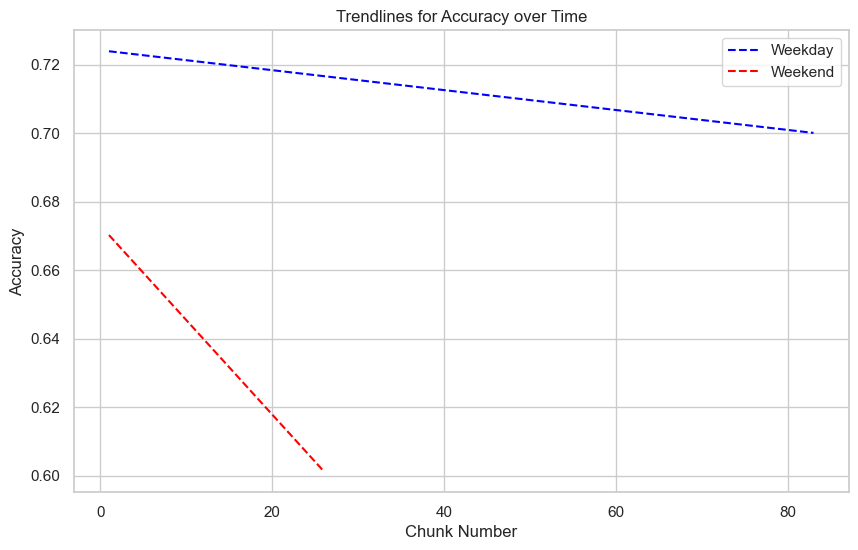

In [49]:
# Plot accuracy scores
plot_trendlines(rf_weekday_acc,rf_weekend_acc)

       Feature  Importance
0      Airline    0.096178
1       Flight    0.015012
2  AirportFrom    0.005679
3    AirportTo    0.005604
4         Time    0.041743
5       Length    0.018345


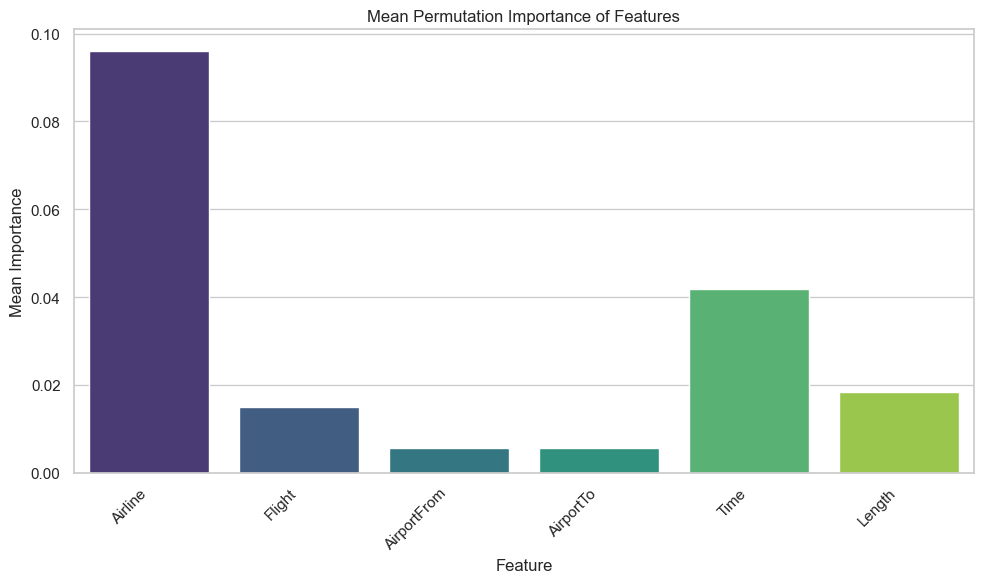

In [50]:
# Plot mean permutation importance scores for weekday
weekday_pi_rf_df= plot_permutation_importance(weekday_rf_importance_df)

       Feature  Importance
0      Airline    0.073623
1       Flight    0.012510
2  AirportFrom    0.005220
3    AirportTo    0.003612
4         Time    0.013732
5       Length    0.014426


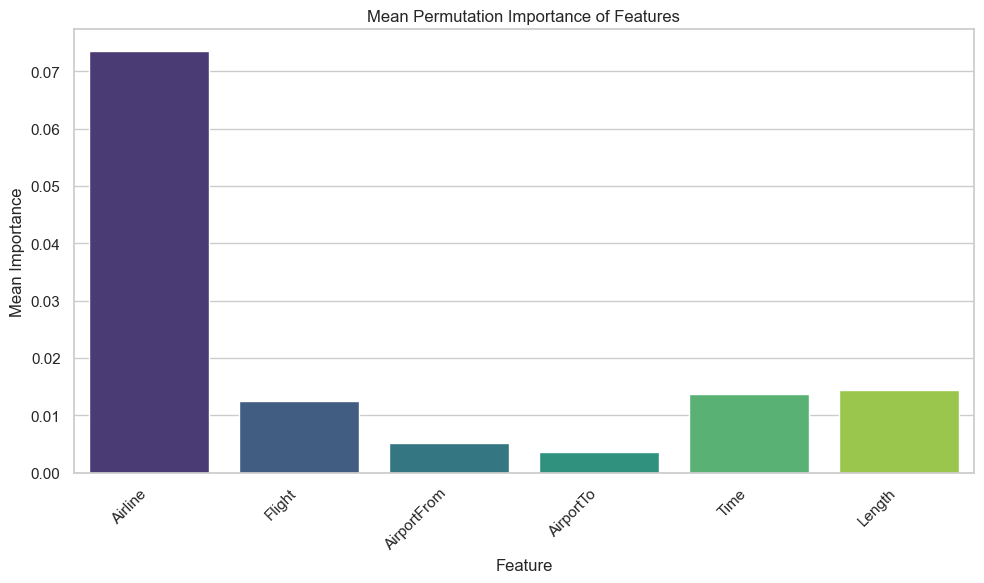

In [51]:
# Plot mean permutation importance scores for weekend
weekend_pi_rf_df = plot_permutation_importance(weekend_rf_importance_df)

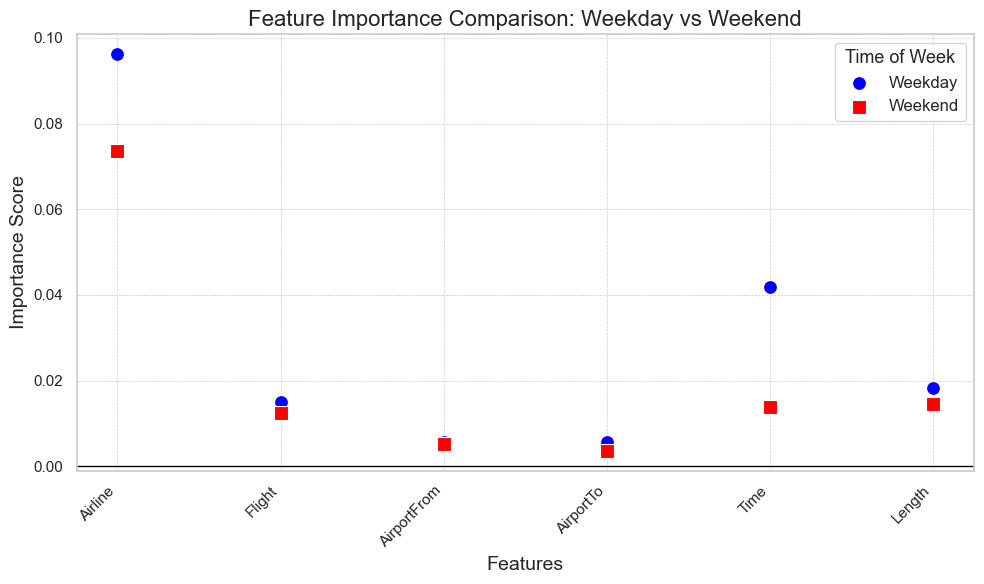

In [52]:
# Plot mean permutation importance scores
plt.figure(figsize=(10, 6))

# Plot the weekday feature importances
sns.scatterplot(x=weekday_pi_rf_df['Feature'], y=weekday_pi_rf_df['Importance'], 
                color='blue', s=100, marker='o', label='Weekday')

# Plot the weekend feature importances
sns.scatterplot(x=weekend_pi_rf_df['Feature'], y=weekend_pi_rf_df['Importance'], 
                color='red', s=100, marker='s', label='Weekend')


plt.title('Feature Importance Comparison: Weekday vs Weekend', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black', linewidth=1.0)  # Adding a horizontal line at y=0 for reference
plt.legend(title='Time of Week', title_fontsize='13', fontsize='12')
plt.tight_layout()
plt.show()

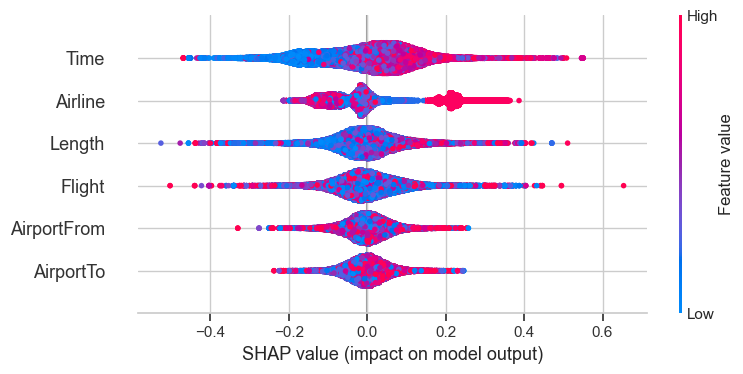

In [53]:
# SHAP Summary plot for weekday dataset
rf_weekday_shap_values = plot_tree_shap_graph(X_test,rf_model)

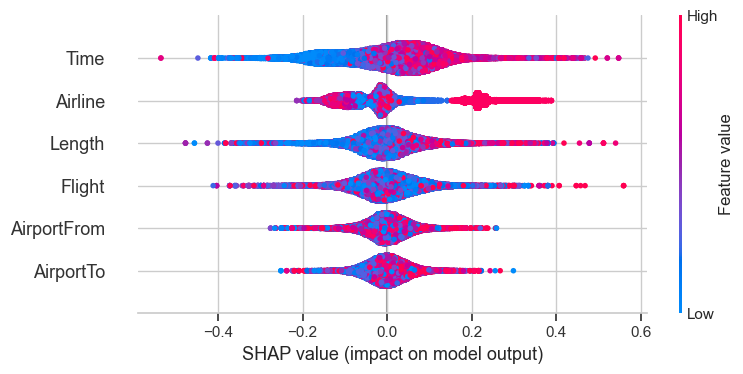

In [54]:
# SHAP Summary plot for weekend dataset
rf_weekend_shap_values = plot_tree_shap_graph(X2,rf_model)

In [55]:
rf_weekend_shap_values.shape

(128835, 6)

In [56]:
# Calculate mean, variance and skewness for weekday dataset
rf_weekday_shap_metrics = calculate_shap_metrics_lr(rf_weekday_shap_values)

In [57]:
rf_weekday_shap_metrics

,feature,mean,variance,skewness
0,Airline,0.000248,0.013046,1.077292
1,Flight,-0.000287,0.005005,0.250956
2,AirportFrom,-0.000073,0.002497,-0.071254
3,AirportTo,-0.000068,0.002122,0.120197
4,Time,-0.000412,0.012852,-0.255051
5,Length,-0.000264,0.005623,0.211500


In [58]:
# Calculate mean, variance and skewness for weekday dataset
rf_weekend_shap_metrics = calculate_shap_metrics_lr(rf_weekend_shap_values)
rf_weekend_shap_metrics

,feature,mean,variance,skewness
0,Airline,-0.000690,0.013349,1.158072
1,Flight,-0.002787,0.004239,0.032155
2,AirportFrom,-0.000415,0.002211,-0.169206
3,AirportTo,-0.000197,0.001971,0.060945
4,Time,0.002486,0.011233,-0.312174
5,Length,0.000708,0.004884,0.217953


In [59]:
# Identify statistical differences in SHAP metrics
import numpy as np
from scipy.stats import ttest_ind, ks_2samp

train_stats = rf_weekday_shap_metrics.set_index('feature').to_dict('index')
test_stats = rf_weekend_shap_metrics.set_index('feature').to_dict('index')

n_samples = 1000
significance_level = 0.05

# Function to simulate SHAP values based on mean and variance
def simulate_shap_values(mean, variance, n_samples):
    return np.random.normal(loc=mean, scale=np.sqrt(variance), size=n_samples)

# Simulating SHAP values for training and testing datasets
shap_train = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
              for feature, stats in train_stats.items()}

shap_test = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
             for feature, stats in test_stats.items()}

# Perform t-test and KS-test for each feature
test_results = {}
for feature in shap_train.keys():
    t_stat, t_p_value = ttest_ind(shap_train[feature], shap_test[feature], equal_var=True)
    ks_stat, ks_p_value = ks_2samp(shap_train[feature], shap_test[feature])
    
    # Determine if the results are significant
    t_significant = t_p_value < significance_level
    ks_significant = ks_p_value < significance_level
    
    test_results[feature] = {
        't-test': {'t_stat': t_stat, 'p_value': t_p_value, 'significant': t_significant},
        'ks-test': {'ks_stat': ks_stat, 'p_value': ks_p_value, 'significant': ks_significant}
    }

for feature, results in test_results.items():
    print(f"Feature: {feature}")
    print(f"  t-test: t_stat={results['t-test']['t_stat']:.4f}, p_value={results['t-test']['p_value']:.4e}, "
          f"{'Significant' if results['t-test']['significant'] else 'Not Significant'}")
    print(f"  KS-test: ks_stat={results['ks-test']['ks_stat']:.4f}, p_value={results['ks-test']['p_value']:.4e}, "
          f"{'Significant' if results['ks-test']['significant'] else 'Not Significant'}")
    print()

print("Summary of features with significant differences:")
for feature, results in test_results.items():
    if results['t-test']['significant'] or results['ks-test']['significant']:
        print(f"Feature: {feature}")
        if results['t-test']['significant']:
            print(f"  Significant difference in mean based on t-test (p={results['t-test']['p_value']:.4e})")
        if results['ks-test']['significant']:
            print(f"  Significant difference in distribution based on KS-test (p={results['ks-test']['p_value']:.4e})")

Feature: Airline
  t-test: t_stat=1.6978, p_value=8.9708e-02, Not Significant
  KS-test: ks_stat=0.0430, p_value=3.1368e-01, Not Significant

Feature: Flight
  t-test: t_stat=2.4038, p_value=1.6318e-02, Significant
  KS-test: ks_stat=0.0800, p_value=3.3111e-03, Significant

Feature: AirportFrom
  t-test: t_stat=-0.9936, p_value=3.2053e-01, Not Significant
  KS-test: ks_stat=0.0470, p_value=2.1940e-01, Not Significant

Feature: AirportTo
  t-test: t_stat=1.4763, p_value=1.4002e-01, Not Significant
  KS-test: ks_stat=0.0520, p_value=1.3385e-01, Not Significant

Feature: Time
  t-test: t_stat=-1.6887, p_value=9.1442e-02, Not Significant
  KS-test: ks_stat=0.0530, p_value=1.2052e-01, Not Significant

Feature: Length
  t-test: t_stat=-0.8978, p_value=3.6941e-01, Not Significant
  KS-test: ks_stat=0.0360, p_value=5.3628e-01, Not Significant

Summary of features with significant differences:
Feature: Flight
  Significant difference in mean based on t-test (p=1.6318e-02)
  Significant differen

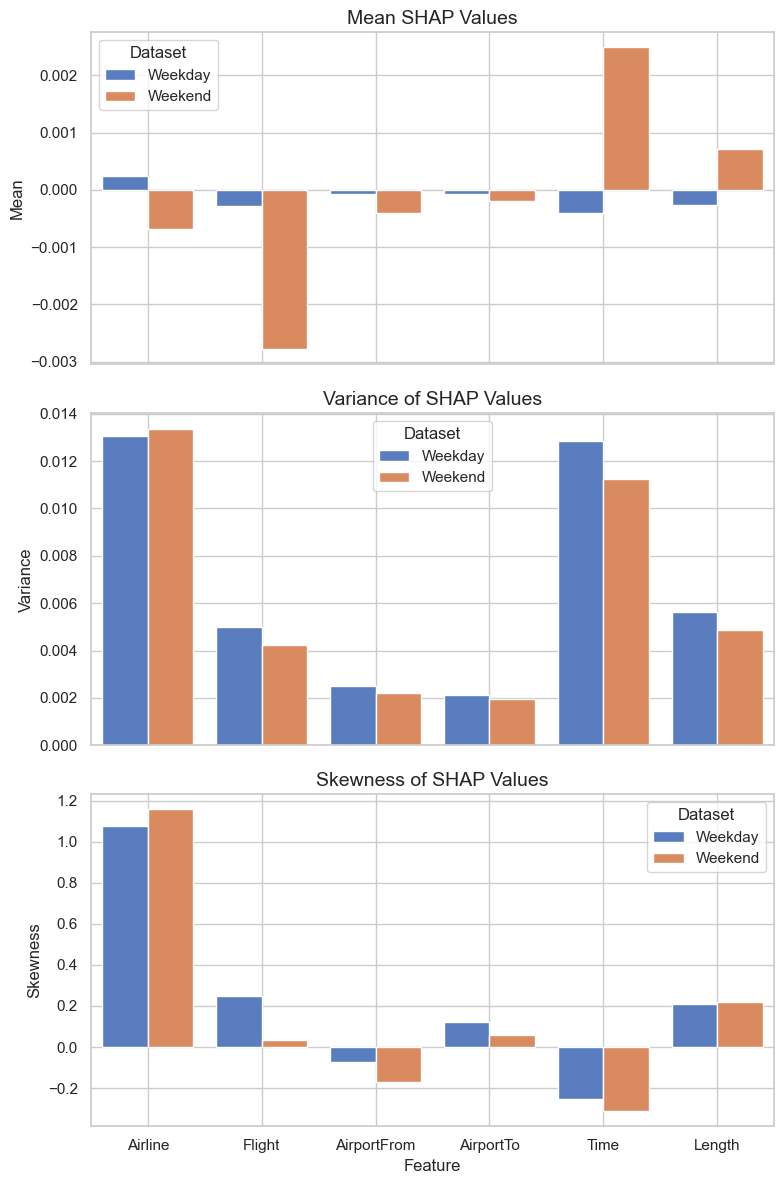

In [60]:
# Plot SHAP metrics
rf_weekday_shap_metrics['Dataset'] = 'Weekday'
rf_weekend_shap_metrics['Dataset'] = 'Weekend'

# Combine the two dataframes into one
combined_shap_metrics = pd.concat([rf_weekday_shap_metrics, rf_weekend_shap_metrics])

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
palette = sns.color_palette("muted")
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot mean SHAP values
sns.barplot(ax=axes[0], x='feature', y='mean', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[0].set_title('Mean SHAP Values', fontsize=14)
axes[0].set_ylabel('Mean', fontsize=12)
axes[0].grid(True)

# Plot variance of SHAP values
sns.barplot(ax=axes[1], x='feature', y='variance', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[1].set_title('Variance of SHAP Values', fontsize=14)
axes[1].set_ylabel('Variance', fontsize=12)
axes[1].grid(True)

# Plot skewness of SHAP values
sns.barplot(ax=axes[2], x='feature', y='skewness', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[2].set_title('Skewness of SHAP Values', fontsize=14)
axes[2].set_xlabel('Feature', fontsize=12)
axes[2].set_ylabel('Skewness', fontsize=12)
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [61]:
# Calculate MCR for Random Forests - Weekday dataset
from sklearn.metrics import accuracy_score
# Calculate the baseline accuracy on the test set
baseline_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
baseline_mcr = 1 - baseline_accuracy

def calculate_mcr(model, X_test, y_test, feature_index):
    X_permuted = X_test.copy()
    X_permuted.iloc[:, feature_index] = np.random.permutation(X_permuted.iloc[:, feature_index])  # Permute the feature
    accuracy = accuracy_score(y_test, model.predict(X_permuted))
    mcr = 1 - accuracy
    return mcr

# Calculate MCR+ and MCR- for each feature
mcr_plus = []
mcr_minus = []

for feature_index in range(X.shape[1]):
    mcr_values = []
    for _ in range(10):  # Permute 10 times for each feature to get a stable estimate
        mcr_values.append(calculate_mcr(rf_model, X_test, y_test, feature_index))
    
    mcr_plus.append(max(mcr_values) - baseline_mcr)
    mcr_minus.append(min(mcr_values) - baseline_mcr)

mcr_plus = np.array(mcr_plus)
mcr_minus = np.array(mcr_minus)

# Print the MCR+ and MCR- for each feature
for i, (mcr_p, mcr_m) in enumerate(zip(mcr_plus, mcr_minus)):
    print(f"Feature {i}: MCR+ = {mcr_p:.4f}, MCR- = {mcr_m:.4f}")

Feature 0: MCR+ = 0.0971, MCR- = 0.0941
Feature 1: MCR+ = 0.0161, MCR- = 0.0133
Feature 2: MCR+ = 0.0074, MCR- = 0.0053
Feature 3: MCR+ = 0.0073, MCR- = 0.0037
Feature 4: MCR+ = 0.0431, MCR- = 0.0412
Feature 5: MCR+ = 0.0201, MCR- = 0.0176


In [62]:
mcr_weekday_df = pd.DataFrame({
    'Feature': X.columns,
    'MCR+': mcr_plus,
    'MCR-': mcr_minus
})

# Display the DataFrame
print(mcr_weekday_df)

       Feature      MCR+      MCR-
0      Airline  0.097130  0.094126
1       Flight  0.016084  0.013324
2  AirportFrom  0.007372  0.005269
3    AirportTo  0.007299  0.003727
4         Time  0.043105  0.041156
5       Length  0.020054  0.017578


In [63]:
# Calculate MCR bounds for weekend dataset
baseline_accuracy = accuracy_score(y2, rf_model.predict(X2))
baseline_mcr = 1 - baseline_accuracy

# Calculate MCR+ and MCR- for each feature
mcr_plus = []
mcr_minus = []

for feature_index in range(X.shape[1]):
    mcr_values = []
    for _ in range(10):  # Permute 10 times for each feature to get a stable estimate
        mcr_values.append(calculate_mcr(rf_model, X2, y2, feature_index))
    
    mcr_plus.append(max(mcr_values) - baseline_mcr)
    mcr_minus.append(min(mcr_values) - baseline_mcr)

mcr_weekend_df = pd.DataFrame({
    'Feature': X.columns,
    'MCR+': mcr_plus,
    'MCR-': mcr_minus
})

print(mcr_weekend_df)

       Feature      MCR+      MCR-
0      Airline  0.074258  0.072255
1       Flight  0.013940  0.011883
2  AirportFrom  0.006535  0.004316
3    AirportTo  0.004812  0.002787
4         Time  0.036357  0.033865
5       Length  0.016719  0.014212


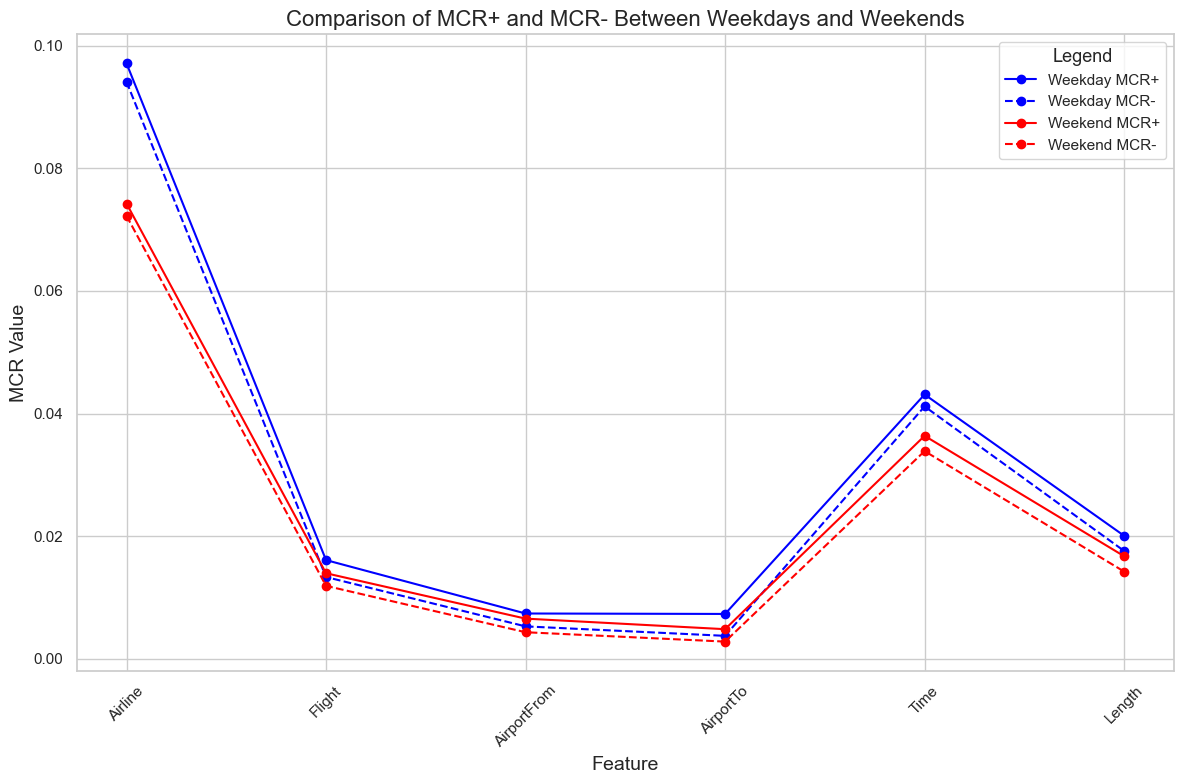

In [64]:
# Plot MCR Bounds
plt.figure(figsize=(12, 8))
# Plotting Weekday MCR+ and MCR-
plt.plot(mcr_weekday_df['Feature'], mcr_weekday_df['MCR+'], marker='o', color='blue', label='Weekday MCR+')
plt.plot(mcr_weekday_df['Feature'], mcr_weekday_df['MCR-'], marker='o', color='blue', linestyle='--', label='Weekday MCR-')

# Plotting Weekend MCR+ and MCR-
plt.plot(mcr_weekend_df['Feature'], mcr_weekend_df['MCR+'], marker='o', color='red', label='Weekend MCR+')
plt.plot(mcr_weekend_df['Feature'], mcr_weekend_df['MCR-'], marker='o', color='red', linestyle='--', label='Weekend MCR-')

plt.title('Comparison of MCR+ and MCR- Between Weekdays and Weekends', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('MCR Value', fontsize=14)
plt.xticks(rotation=45)

plt.legend(title='Legend', title_fontsize='13', fontsize='11', loc='upper right')
plt.tight_layout()
plt.show()

In [65]:
# Compare MCR bounds
compare_mcr_bounds(mcr_weekday_df, mcr_weekend_df)

Features with significant differences (p < 0.05) according to the T-test:

Features with significant differences (p < 0.05) according to the KS-test:


# Model Neural Network

In [66]:
!pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [67]:
# Fit a neural network model to weekday dataset

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Define the model
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
7185/7185 ━━━━━━━━━━━━━━━━━━━━ 2s 294us/step - accuracy: 0.5312 - loss: 2.0435 - val_accuracy: 0.5760 - val_loss: 0.7879
Epoch 2/5
7185/7185 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step - accuracy: 0.5437 - loss: 0.9290 - val_accuracy: 0.5812 - val_loss: 0.7048
Epoch 3/5
7185/7185 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step - accuracy: 0.5512 - loss: 0.8038 - val_accuracy: 0.5232 - val_loss: 0.7222
Epoch 4/5
7185/7185 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step - accuracy: 0.5604 - loss: 0.7247 - val_accuracy: 0.5776 - val_loss: 0.6750
Epoch 5/5
7185/7185 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step - accuracy: 0.5731 - loss: 0.6849 - val_accuracy: 0.5755 - val_loss: 0.6753


In [68]:

# Make predictions on the test set
y_pred_nn_probs = nn_model.predict(X_test)
y_pred_nn = (y_pred_nn_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

print("Classification Report (Neural Network):")
print(classification_report(y_test, y_pred_nn))


3849/3849 ━━━━━━━━━━━━━━━━━━━━ 1s 186us/step
Classification Report (Neural Network):
              precision    recall  f1-score   support

           0       0.57      0.93      0.71     67832
           1       0.62      0.14      0.23     55333

    accuracy                           0.57    123165
   macro avg       0.59      0.53      0.47    123165
weighted avg       0.59      0.57      0.49    123165



In [69]:
# Make predictions on the weekend dataset
from sklearn.metrics import classification_report, confusion_matrix
y2_pred_probs = nn_model.predict(X2)
y2_pred = (y2_pred_probs > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y2, y2_pred))

print("\nClassification Report:")
print(classification_report(y2, y2_pred))

4027/4027 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step
Confusion Matrix:
[[68105  5422]
 [48628  6680]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.93      0.72     73527
           1       0.55      0.12      0.20     55308

    accuracy                           0.58    128835
   macro avg       0.57      0.52      0.46    128835
weighted avg       0.57      0.58      0.49    128835



In [70]:
# Calculate permutation importance chunks for weekday and weekend datasets
weekday_nn_importance_df = calculate_permutation_importance_chunks(nn_model, X_test, y_test, chunk_size=5000)
weekend_nn_importance_df = calculate_permutation_importance_chunks(nn_model, X2, y2, chunk_size=5000)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 185us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step
157/157 ━━━

In [71]:
# Compare statistical differences between importance scores
compare_importance_scores(weekday_nn_importance_df, weekend_nn_importance_df)

Features with significant differences (p < 0.05) according to the T-test:
- Airline: p-value = 0.0224
- Flight: p-value = 0.0000
- Time: p-value = 0.0004

Features with significant differences (p < 0.05) according to the KS-test:
- Airline: p-value = 0.0004
- Flight: p-value = 0.0000
- AirportFrom: p-value = 0.0260
- Time: p-value = 0.0000


In [72]:
# Calculate window wise accuracy scores
nn_weekday_imp, nn_weekday_acc = calculate_permutation_importance_all_values(nn_model, X, y, chunk_size=5000)
nn_weekend_imp, nn_weekend_acc = calculate_permutation_importance_all_values(nn_model, X2, y2, chunk_size=5000)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 166us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 180us/step
157/157 ━━━

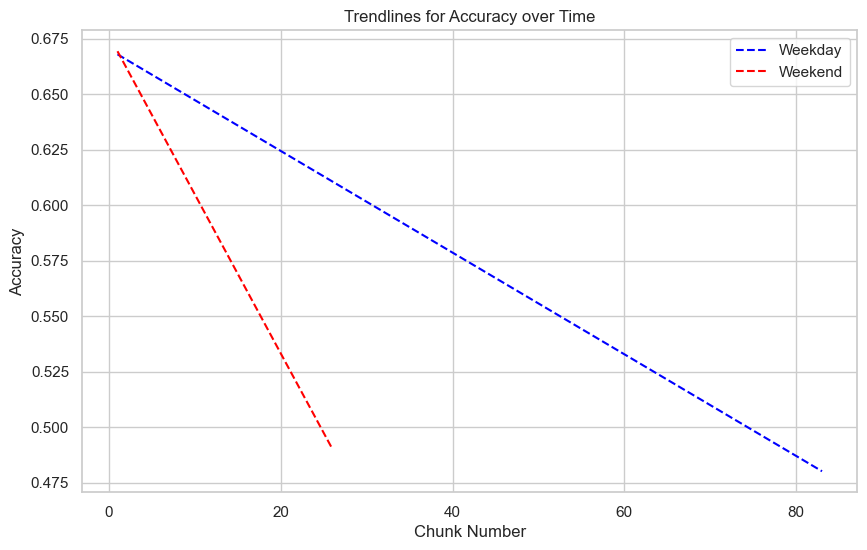

In [73]:
# Plot accuracy trendline
plot_trendlines(nn_weekday_acc,nn_weekend_acc)

       Feature  Importance
0      Airline    0.002961
1       Flight    0.003820
2  AirportFrom    0.000406
3    AirportTo    0.000856
4         Time    0.005779
5       Length    0.000512


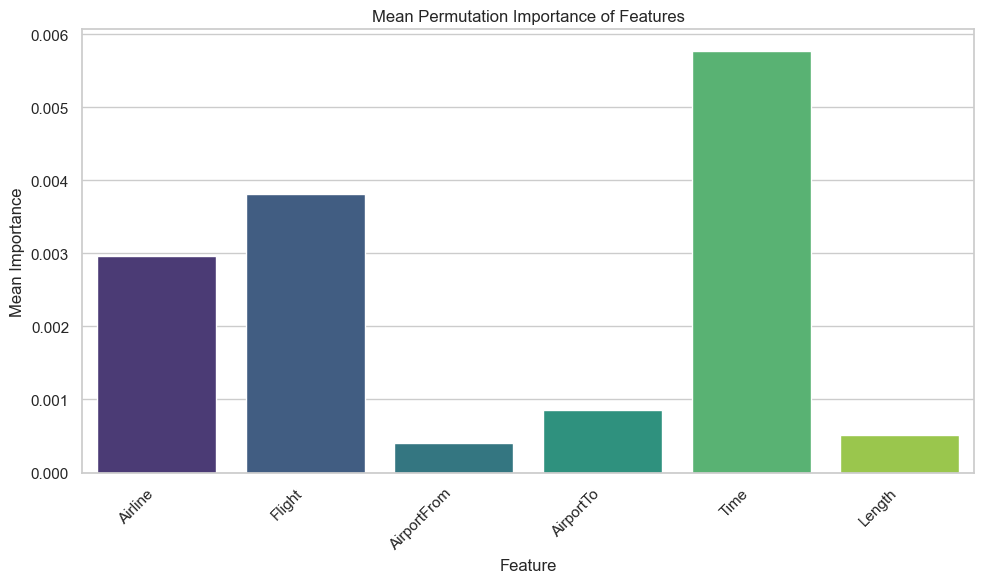

In [74]:
# Plot mean permutation importance scores for weekday
weekday_pi_nn_df = plot_permutation_importance(weekday_nn_importance_df)

       Feature  Importance
0      Airline    0.002195
1       Flight    0.002137
2  AirportFrom    0.000239
3    AirportTo    0.000602
4         Time    0.002431
5       Length    0.000462


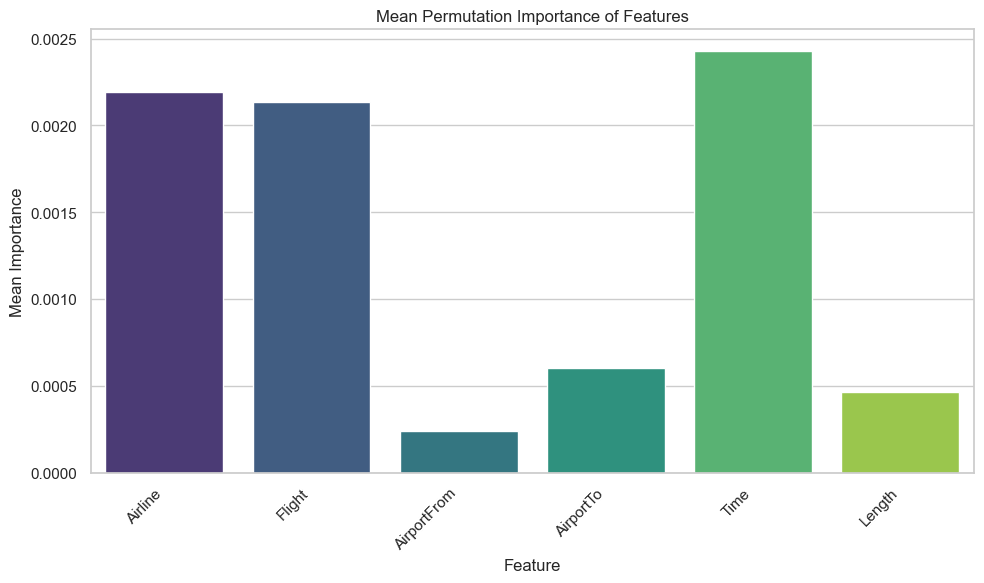

In [83]:
# Plot mean permutation importance scores for weekend
weekend_pi_nn_df = plot_permutation_importance(weekend_nn_importance_df)

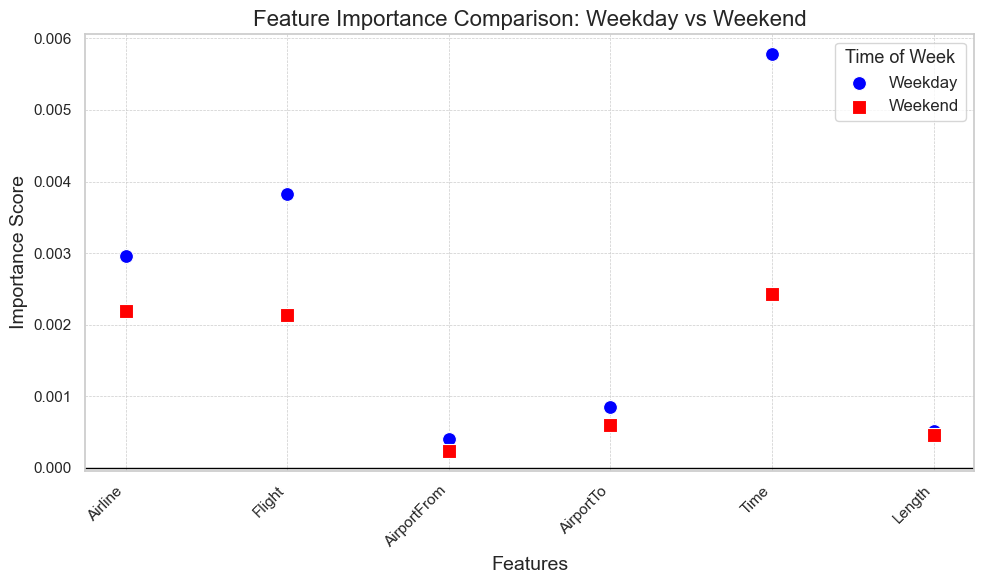

In [84]:
# Plot mean importance scores for both datasets

plt.figure(figsize=(10, 6))
# Plot the weekday feature importances
sns.scatterplot(x=weekday_pi_nn_df['Feature'], y=weekday_pi_nn_df['Importance'], 
                color='blue', s=100, marker='o', label='Weekday')

# Plot the weekend feature importances
sns.scatterplot(x=weekend_pi_nn_df['Feature'], y=weekend_pi_nn_df['Importance'], 
                color='red', s=100, marker='s', label='Weekend')
plt.title('Feature Importance Comparison: Weekday vs Weekend', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black', linewidth=1.0)  # Adding a horizontal line at y=0 for reference
plt.legend(title='Time of Week', title_fontsize='13', fontsize='12')
plt.tight_layout()
plt.show()

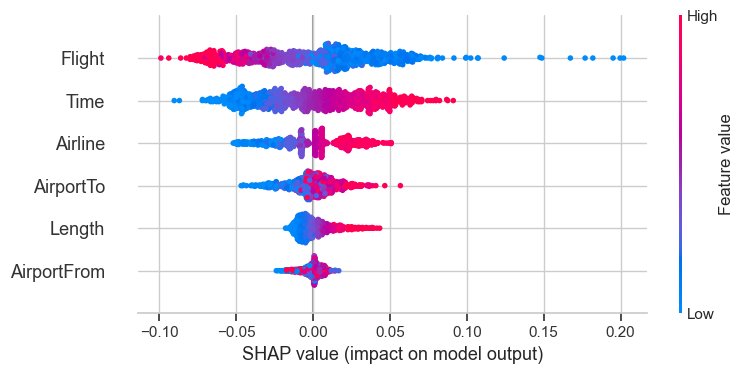

In [85]:
# SHAP Summary plot for weekday
nn_weekday_shap_values = plot_nn_shap_graph(X_test,nn_model)

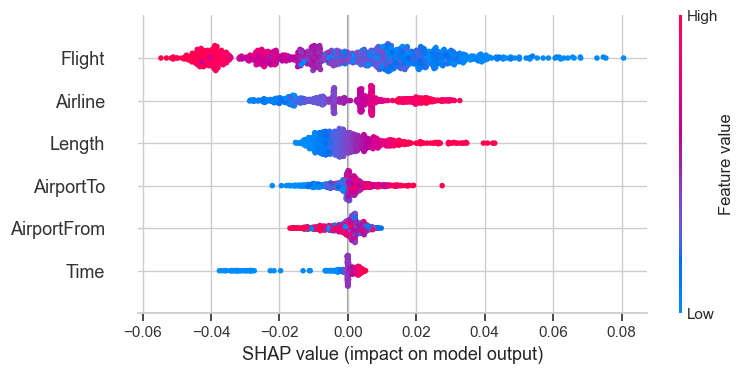

In [86]:
# Plot SHAP Summary plot for weekend
nn_weekend_shap_values = plot_nn_shap_graph(X2,nn_model)

In [87]:
# Calculate mean, variance and skewness for weekday
nn_weekday_shap_metrics = calculate_shap_metrics_lr(nn_weekday_shap_values)
nn_weekday_shap_metrics

,feature,mean,variance,skewness
0,Airline,2.775558e-19,0.000567,-0.109418
1,Flight,-1.270362e-14,0.001900,0.422592
2,AirportFrom,-2.968605e-15,0.000038,-0.847889
3,AirportTo,-2.292000e-15,0.000190,-0.269451
4,Time,-1.133493e-14,0.001276,0.070559
5,Length,6.375664e-15,0.000107,1.315886


In [88]:
# Calculate mean, variance and skewness for weekday
nn_weekend_shap_metrics = calculate_shap_metrics_lr(nn_weekend_shap_values)
nn_weekend_shap_metrics

,feature,mean,variance,skewness
0,Airline,-2.220446e-19,0.000214,0.165939
1,Flight,2.775558e-19,0.000695,-0.019980
2,AirportFrom,5.551115e-20,0.000020,-1.170824
3,AirportTo,0.000000e+00,0.000030,-0.122157
4,Time,0.000000e+00,0.000035,-4.630255
5,Length,2.775558e-20,0.000078,1.393009


In [89]:
# Statistical tests for differences in SHAP metrics
import numpy as np
from scipy.stats import ttest_ind, ks_2samp

train_stats = nn_weekday_shap_metrics.set_index('feature').to_dict('index')
test_stats = nn_weekend_shap_metrics.set_index('feature').to_dict('index')

n_samples = 1000
significance_level = 0.05

def simulate_shap_values(mean, variance, n_samples):
    return np.random.normal(loc=mean, scale=np.sqrt(variance), size=n_samples)

# Simulating SHAP values for training and testing datasets
shap_train = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
              for feature, stats in train_stats.items()}

shap_test = {feature: simulate_shap_values(stats['mean'], stats['variance'], n_samples) 
             for feature, stats in test_stats.items()}

# Perform t-test and KS-test for each feature
test_results = {}
for feature in shap_train.keys():
    t_stat, t_p_value = ttest_ind(shap_train[feature], shap_test[feature], equal_var=True)
    ks_stat, ks_p_value = ks_2samp(shap_train[feature], shap_test[feature])
    
    # Determine if the results are significant
    t_significant = t_p_value < significance_level
    ks_significant = ks_p_value < significance_level
    
    test_results[feature] = {
        't-test': {'t_stat': t_stat, 'p_value': t_p_value, 'significant': t_significant},
        'ks-test': {'ks_stat': ks_stat, 'p_value': ks_p_value, 'significant': ks_significant}
    }

# Print results and highlight which are significantly different
for feature, results in test_results.items():
    print(f"Feature: {feature}")
    print(f"  t-test: t_stat={results['t-test']['t_stat']:.4f}, p_value={results['t-test']['p_value']:.4e}, "
          f"{'Significant' if results['t-test']['significant'] else 'Not Significant'}")
    print(f"  KS-test: ks_stat={results['ks-test']['ks_stat']:.4f}, p_value={results['ks-test']['p_value']:.4e}, "
          f"{'Significant' if results['ks-test']['significant'] else 'Not Significant'}")
    print()

print("Summary of features with significant differences:")
for feature, results in test_results.items():
    if results['t-test']['significant'] or results['ks-test']['significant']:
        print(f"Feature: {feature}")
        if results['t-test']['significant']:
            print(f"  Significant difference in mean based on t-test (p={results['t-test']['p_value']:.4e})")
        if results['ks-test']['significant']:
            print(f"  Significant difference in distribution based on KS-test (p={results['ks-test']['p_value']:.4e})")

Feature: Airline
  t-test: t_stat=2.1935, p_value=2.8385e-02, Significant
  KS-test: ks_stat=0.1510, p_value=2.3212e-10, Significant

Feature: Flight
  t-test: t_stat=0.6147, p_value=5.3884e-01, Not Significant
  KS-test: ks_stat=0.1460, p_value=1.0354e-09, Significant

Feature: AirportFrom
  t-test: t_stat=0.4255, p_value=6.7050e-01, Not Significant
  KS-test: ks_stat=0.1220, p_value=6.6698e-07, Significant

Feature: AirportTo
  t-test: t_stat=-0.5850, p_value=5.5862e-01, Not Significant
  KS-test: ks_stat=0.2180, p_value=3.2027e-21, Significant

Feature: Time
  t-test: t_stat=0.2537, p_value=7.9976e-01, Not Significant
  KS-test: ks_stat=0.3610, p_value=2.7251e-58, Significant

Feature: Length
  t-test: t_stat=-0.6515, p_value=5.1477e-01, Not Significant
  KS-test: ks_stat=0.0570, p_value=7.7611e-02, Not Significant

Summary of features with significant differences:
Feature: Airline
  Significant difference in mean based on t-test (p=2.8385e-02)
  Significant difference in distributi

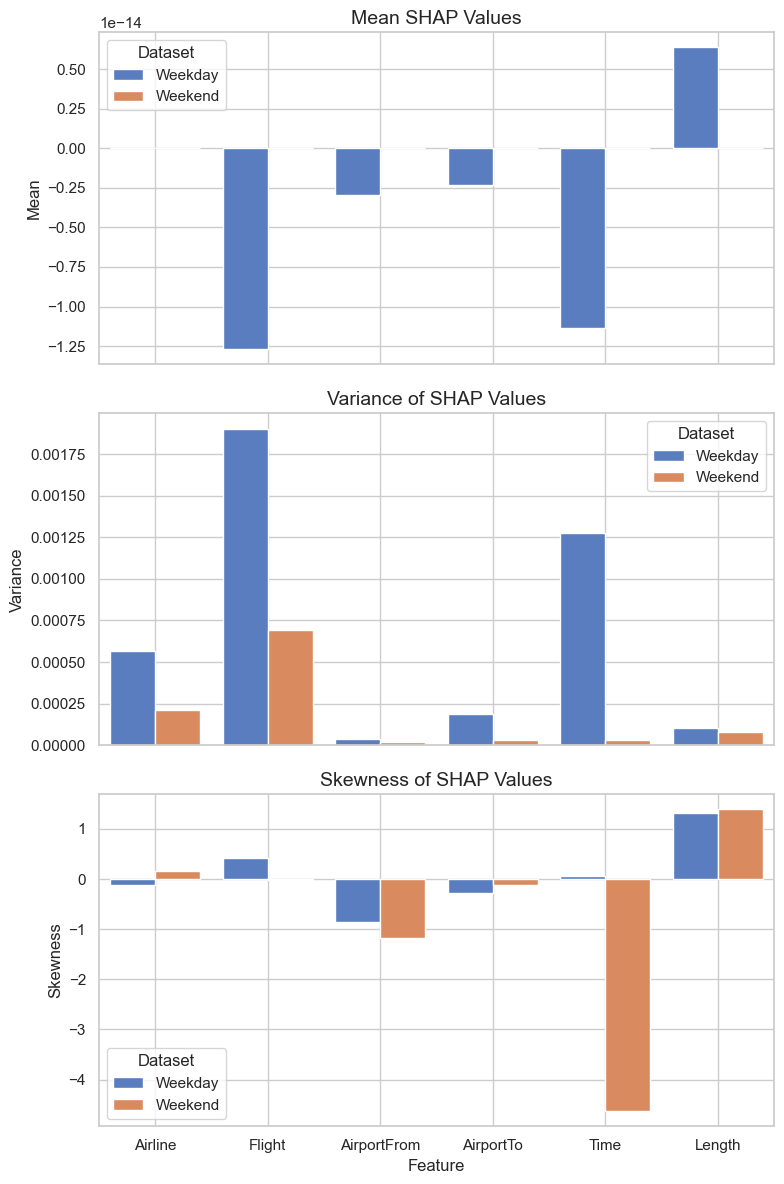

In [90]:
# Plot SHAP metrics
nn_weekday_shap_metrics['Dataset'] = 'Weekday'
nn_weekend_shap_metrics['Dataset'] = 'Weekend'

# Combine the two dataframes into one
combined_shap_metrics = pd.concat([nn_weekday_shap_metrics, nn_weekend_shap_metrics])

sns.set(style="whitegrid")
palette = sns.color_palette("muted")

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

# Plot mean SHAP values
sns.barplot(ax=axes[0], x='feature', y='mean', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[0].set_title('Mean SHAP Values', fontsize=14)
axes[0].set_ylabel('Mean', fontsize=12)
axes[0].grid(True)

# Plot variance of SHAP values
sns.barplot(ax=axes[1], x='feature', y='variance', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[1].set_title('Variance of SHAP Values', fontsize=14)
axes[1].set_ylabel('Variance', fontsize=12)
axes[1].grid(True)

# Plot skewness of SHAP values
sns.barplot(ax=axes[2], x='feature', y='skewness', data=combined_shap_metrics, hue='Dataset', palette=palette)
axes[2].set_title('Skewness of SHAP Values', fontsize=14)
axes[2].set_xlabel('Feature', fontsize=12)
axes[2].set_ylabel('Skewness', fontsize=12)
axes[2].grid(True)

plt.tight_layout()
plt.show()